In [1]:
import torch
from models.common import DetectMultiBackend
from utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages, LoadScreenshots, LoadStreams

from utils.general import (LOGGER, Profile, check_file, check_img_size, check_imshow, check_requirements, colorstr, cv2,
                           increment_path, non_max_suppression, print_args, scale_boxes, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, smart_inference_mode
from utils.general import  check_dataset
from pathlib import Path
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
classDict = {0:"bed",1:"bird",2:"cat",3:"dog",4:"down",5:"eight",6:"five",7:"four",8:"go",9:"happy",10:"house",11:"left",12:"marvin",13:"nine",14:"no",15:"off",16:"on",17:"one",18:"right",19:"seven",20:"sheila",21:"six",22:"stop",23:"three",24:"tree",25:"two",26:"up",27:"wow",28:"yes",29:"zero"}

In [3]:
weights ='runs/train/test/weights/best.pt'
device = 'cpu'
half=False
dnn=False
data = 'data/sound.yaml'

model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
stride, names, pt = model.stride, model.names, model.pt

Fusing layers... 
YOLOv5s summary: 157 layers, 7091035 parameters, 0 gradients


In [4]:
data_dict = check_dataset(data)
val_path = data_dict['val']
train_path = data_dict['train']

batch_size = 8 # total batch size for all GPUs 
batches = 50
imgsz = 640 # train, val image size (pixels) 1920*1080
rect = False # rectangular training 
noval = False # only validate final epoch
evolve = 0 # evolve hyperparameters for x generations
cache = '' # cache images in "ram" (default) or "disk"
image_weights = False # use weighted image selection for training
single_cls = False # train multi-class data as single-class
workers = 8 # maximum number of dataloader workers
project = 'runs/val' # save to project/name
name = 'jupyter_val' # save to project/name
exist_ok = True
# source = 'image/img/0ab3b47d_nohash_0.jpg' #prediction 
# source = 'image/img/5.jpg' #prediction 
vid_stride=1
bs = batch_size  # batch_size
conf_thres=0.25
iou_thres=0.45
classes=None
agnostic_nms=False
max_det=1000
save_dir = 'predict/'
line_thickness = 1
save_img = 1
save_txt = 1

In [5]:
def frames_to_samples(frames, hop_length=512, n_fft=None):
    offset = 0
    if n_fft is not None:
        offset = int(n_fft // 2)

    return (np.asanyarray(frames) * hop_length + offset).astype(int)

In [6]:
def prediction(signals,classes,hop_length,frame_length,top_db,imagename,labelname,show_image = False):
    
    t=0   
    # Short-time Fourier Transformation on our audio data
    audio_stft = librosa.core.stft(signals, hop_length=hop_length, n_fft=256)
    # gathering the absolute values for all values in our audio_stft 
    spectrogram = np.abs(audio_stft)
    combined_fft = librosa.amplitude_to_db(spectrogram, ref=np.max) # Converting the amplitude to decibels
    
    fig = plt.figure(figsize=(8,8),frameon=False)
    
    plt.subplot(152)
    rotated_img = ndimage.rotate(combined_fft, 1*90)
#     plt.imshow(rotated_img, cmap=plt.cm.gray)
    plt.axis('off')
    plt.imsave(save_dir+'test/test.jpg',rotated_img)
    load_img_path = save_dir+'test/test.jpg'
    
    drow_bounding_box(load_img_path)


In [7]:
def drow_bounding_box(impath):
    dataset = LoadImages(impath, img_size=imgsz, stride=stride, auto=pt, vid_stride=vid_stride)
    vid_path, vid_writer = [None] * bs, [None] * bs

    # Run inference
    # model.warmup(imgsz=(1 if pt or model.triton else bs, 3, *imgsz))  # warmup
    seen, windows, dt = 0, [], (Profile(), Profile(), Profile())

    for path, im, im0s, vid_cap, s in dataset:
        with dt[0]:
            im = torch.from_numpy(im).to(model.device)
            im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
            im /= 255  # 0 - 255 to 0.0 - 1.0
            if len(im.shape) == 3:
                im = im[None]  # expand for batch dim

        # Inference
        with dt[1]:
    #         visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
            pred = model(im, augment=False, visualize=False)

        # NMS
        with dt[2]:
            pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)


        # Process predictions
        for i, det in enumerate(pred):  # per image
            seen += 1
            p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)
            p = Path(p)  # to Path
            save_path = str(save_dir + p.name)  # im.jpg
            txt_path = str(save_dir + 'labels' + p.stem) 
            #+ ('' if dataset.mode == 'image' else f'_{frame}')  # im.txt
            s += '%gx%g ' % im.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            imc = im0.copy()  # for save_crop
            annotator = Annotator(im0, line_width=line_thickness, example=str(names))
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, 5].unique():
                    n = (det[:, 5] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) #if save_conf else (cls, *xywh)  # label format
                        with open(f'{txt_path}.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img:  # Add bbox to image
                        c = int(cls)  # integer class
                        label = classDict[c] #if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}')
                        annotator.box_label(xyxy, label, color=colors(c, True))

            im0 = annotator.result()
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                    plt.imshow(im0)
                    plt.show()

                else:
                    pass# 'video' or 'stream'

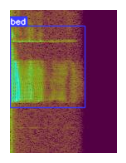

In [8]:
# signal1, sampFreq = librosa.load('../../dataset/google_speech_commands_v0/sheila/00f0204f_nohash_1.wav') 
signal1, sampFreq = librosa.load('../../dataset/google_speech_commands_v0/bed/00f0204f_nohash_0.wav') 



samples_for_image = prediction(signal1,[1,8,5],128,256,25,"alphaa","alphaa",True)

ipd.Audio(data=signal1, rate=sampFreq)